# Task 2: Multi Independent Product with B constrain

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal

from scipy.optimize import linear_sum_assignment, linprog

from scipy import optimize

import sys

sys.path.append('../utils')

from UCB1_multi_constr import UCBMatchingAgent



# Enviroment

In [2]:
class MultiProductPricingEnvironment:
    """
    Multi-product stochastic environment for dynamic pricing with inventory constraints.

    This environment simulates a multi-product pricing scenario where:
    - Each product has its own customer valuation distribution
    - Customers have different preferences for different products
    - Each round represents one customer interaction
    - The customer can purchase multiple products or none at all
    """
    def __init__(self, valuation_distribution,n_samples=100000):
        """
        Initialize the multi-product pricing environment.

        Args:
            valuation_distribution: multi_variate distribution of scipy.stats distribution for each product
        """
        self.valuation_dist = valuation_distribution
        self.n_products = len(valuation_distribution.mean)

        # number of samples to draw from the distribution
        self.n_samples = n_samples

    def demand_probability(self, prices, product_subset):
        """
        Calculate the theoretical probability that a customer purchases
        the given subset of products at given prices.

        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered

        Returns:
            Probability that customer will purchase this product subset

        """
        prob=np.zeros(len(product_subset))

        for i, product_idx in enumerate(product_subset):
            samples = self.valuation_dist.rvs(size=self.n_samples)
            # Calculate the probability that the customer will purchase this product
            prob[i]  = np.mean(samples[:, product_idx] >= prices[product_idx])

        # Return the probability of purchasing each product in the subset for each price in the prices vector
        return prob

    def simulate_round(self, prices, product_subset):
        """
        Simulate one customer interaction for a given product subset and prices.

        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered

        Returns:
            tuple: (products_purchased, total_revenue) where:
                - products_purchased: List of products actually purchased
                - total_revenue: Sum of revenues from purchased products
        """
        if len(product_subset) == 0:
            return [], 0.0

        products_purchased = []
        total_revenue = 0.0

        # Generate customer valuations for all products
        valuations = self.valuation_dist.rvs(size=1)

        # Customer purchases products where valuation >= price
        for product_idx in product_subset:
            if valuations[product_idx] >= prices[product_idx]:
                products_purchased.append(product_idx)
                total_revenue += prices[product_idx]

        return products_purchased, total_revenue

In [3]:

def compute_clairvoyant(prices, environment, T, total_inventory, method='sampling'):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information
    for the multi-product case with a single shared inventory constraint.

    Args:
        prices: List of available prices (assumed to be the same for all products)
        environment: MultiProductPricingEnvironment to get true demand probabilities
        T: Time horizon
        total_inventory: Total shared inventory across all products
        method: 'sampling' for probabilistic sampling, 'lsa' for Linear Sum Assignment

    Returns:
        Dictionary with optimal policy information, including per-product insights.
    """
    n_products = environment.n_products
    n_price_options = len(prices)
    num_vars = n_products * n_price_options

    # Compute true demand probabilities for each (product, price) combination
    demand_probabilities = np.zeros((n_products, n_price_options))
    
    for product_idx in range(n_products):
        for price_idx, price in enumerate(prices):
            demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])

    # Expected revenue per selection for each (product, price) combination
    expected_revenues = np.array(prices) * demand_probabilities

    # Compute optimal gamma distribution (same for both methods)
    gamma_result = compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory)
    
    if gamma_result is None:
        return create_fallback_result(n_products, n_price_options, prices, 
                                    demand_probabilities, expected_revenues)

    gamma = gamma_result['gamma']
    lp_optimal_revenue = gamma_result['lp_optimal_revenue']

    if method == 'sampling':
        return compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                          lp_optimal_revenue, T, n_products, n_price_options)
    elif method == 'lsa':
        return compute_lsa_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                     lp_optimal_revenue, T, n_products, n_price_options)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'sampling' or 'lsa'")

def compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory):
    """
    Solve the LP to get optimal gamma distribution.
    """
    n_products, n_price_options = expected_revenues.shape
    num_vars = n_products * n_price_options

    # Set up linear program (convert maximization to minimization)
    c = -expected_revenues.flatten()

    # Inequality constraints (shared inventory)
    A_ub = [demand_probabilities.flatten()]
    b_ub = [total_inventory / T]

    # Equality constraints (probability distribution for each product)
    A_eq = np.zeros((n_products, num_vars))
    b_eq = np.ones(n_products)

    for product_idx in range(n_products):
        start_idx = product_idx * n_price_options
        end_idx = start_idx + n_price_options
        A_eq[product_idx, start_idx:end_idx] = 1

    bounds = [(0, 1) for _ in range(num_vars)]

    try:
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                              bounds=bounds, method='highs')

        if res.success:
            gamma_flat = res.x
            gamma = gamma_flat.reshape((n_products, n_price_options))
            lp_optimal_revenue = -res.fun * T
            
            return {
                'gamma': gamma,
                'lp_optimal_revenue': lp_optimal_revenue
            }
        else:
            print("Clairvoyant LP failed to converge.")
            return None

    except Exception as e:
        print(f"Clairvoyant LP Error: {e}")
        return None

def compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                               lp_optimal_revenue, T, n_products, n_price_options):
    """
    Compute performance for sampling-based selection (original method).
    """
    optimal_policies = {}
    
    for product_idx in range(n_products):
        best_price_idx_in_dist = np.argmax(gamma[product_idx, :])
        optimal_price_for_product = prices[best_price_idx_in_dist]

        expected_revenue_per_round_product = np.sum(gamma[product_idx, :] * expected_revenues[product_idx, :])
        expected_purchase_prob_product = np.sum(gamma[product_idx, :] * demand_probabilities[product_idx, :])

        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],
            'representative_optimal_price': optimal_price_for_product,
            'expected_revenue_per_round': expected_revenue_per_round_product,
            'purchase_probability': expected_purchase_prob_product,
            'expected_total_revenue_under_dist': expected_revenue_per_round_product * T
        }

    return {
        'method': 'sampling',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues
    }

def compute_lsa_performance(gamma, prices, expected_revenues, demand_probabilities, 
                          lp_optimal_revenue, T, n_products, n_price_options):
    """
    Compute performance for LSA-based selection.
    
    LSA selects the deterministic assignment that maximizes gamma-weighted revenues.
    """
    optimal_policies = {}
    
    # Compute LSA assignment based on gamma-weighted revenues
    cost_matrix = -(expected_revenues * gamma)  # Negative for minimization
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate actual performance of LSA assignment
    lsa_revenue_per_round = 0.0
    lsa_purchases_per_round = 0.0
    
    for product_idx in range(n_products):
        selected_price_idx = col_indices[product_idx]
        selected_price = prices[selected_price_idx]
        
        # Revenue and purchase probability for this deterministic choice
        revenue_per_round = expected_revenues[product_idx, selected_price_idx]
        purchase_prob = demand_probabilities[product_idx, selected_price_idx]
        
        lsa_revenue_per_round += revenue_per_round
        lsa_purchases_per_round += purchase_prob
        
        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],  # Keep original gamma for reference
            'lsa_selected_price_idx': selected_price_idx,
            'lsa_selected_price': selected_price,
            'representative_optimal_price': selected_price,  # For compatibility
            'expected_revenue_per_round': revenue_per_round,
            'purchase_probability': purchase_prob,
            'expected_total_revenue_under_dist': revenue_per_round * T,
            'gamma_weight_at_selection': gamma[product_idx, selected_price_idx]
        }
    
    # Check if LSA assignment respects inventory constraint
    inventory_constraint_rhs = total_inventory / T  # This needs to be passed as parameter
    # Note: We need total_inventory here, but it's not in function signature. 
    # We'll estimate it from the LP constraint that was binding.
    
  
    effective_rounds = T
    
    lsa_total_revenue = lsa_revenue_per_round * effective_rounds
    
    return {
        'method': 'lsa',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,  # LP upper bound
        'lsa_expected_revenue': lsa_total_revenue,  # Actual LSA performance
        'lsa_revenue_per_round': lsa_revenue_per_round,
        'lsa_purchases_per_round': lsa_purchases_per_round,
        'lsa_assignment': col_indices,
        'lsa_effective_rounds': effective_rounds,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues,
        'lsa_vs_lp_ratio': lsa_total_revenue / lp_optimal_revenue if lp_optimal_revenue > 0 else 0
    }

def compute_lsa_performance_with_inventory(gamma, prices, expected_revenues, demand_probabilities, 
                                         lp_optimal_revenue, T, total_inventory, n_products, n_price_options):
    """
    Enhanced LSA performance calculation with explicit inventory constraint checking.
    """
    # Compute LSA assignment
    cost_matrix = -(expected_revenues * gamma)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate LSA performance with inventory constraint
    lsa_revenue_per_round = 0.0
    lsa_purchases_per_round = 0.0
    
    optimal_policies = {}
    
    for product_idx in range(n_products):
        selected_price_idx = col_indices[product_idx]
        selected_price = prices[selected_price_idx]
        
        revenue_per_round = expected_revenues[product_idx, selected_price_idx]
        purchase_prob = demand_probabilities[product_idx, selected_price_idx]
        
        lsa_revenue_per_round += revenue_per_round
        lsa_purchases_per_round += purchase_prob
        
        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],
            'lsa_selected_price_idx': selected_price_idx,
            'lsa_selected_price': selected_price,
            'representative_optimal_price': selected_price,
            'expected_revenue_per_round': revenue_per_round,
            'purchase_probability': purchase_prob,
            'expected_total_revenue_under_dist': revenue_per_round * T,
            'gamma_weight_at_selection': gamma[product_idx, selected_price_idx]
        }
    
    # Check inventory constraint
    if lsa_purchases_per_round > 0:
        max_rounds_lsa = total_inventory / lsa_purchases_per_round
        effective_rounds = min(max_rounds_lsa, T)
        inventory_constraint_binding = max_rounds_lsa < T
    else:
        effective_rounds = T
        inventory_constraint_binding = False
    
    lsa_total_revenue = lsa_revenue_per_round * effective_rounds
    
    return {
        'method': 'lsa',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,
        'lsa_expected_revenue': lsa_total_revenue,
        'lsa_revenue_per_round': lsa_revenue_per_round,
        'lsa_purchases_per_round': lsa_purchases_per_round,
        'lsa_assignment': col_indices,
        'lsa_effective_rounds': effective_rounds,
        'lsa_max_sustainable_rounds': max_rounds_lsa if lsa_purchases_per_round > 0 else T,
        'inventory_constraint_binding': inventory_constraint_binding,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues,
        'lsa_vs_lp_ratio': lsa_total_revenue / lp_optimal_revenue if lp_optimal_revenue > 0 else 0
    }

def create_fallback_result(n_products, n_price_options, prices, demand_probabilities, expected_revenues):
    """Create fallback result when LP fails."""
    optimal_policies = {}
    for product_idx in range(n_products):
        optimal_policies[product_idx] = {
            'optimal_price_distribution': np.ones(n_price_options) / n_price_options,
            'representative_optimal_price': prices[0],
            'expected_revenue_per_round': 0.0,
            'purchase_probability': 0.0,
            'expected_total_revenue_under_dist': 0.0
        }
    
    return {
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': 0.0,
        'optimal_gamma': None,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues
    }

# Enhanced version that needs to be called separately with total_inventory
def compute_clairvoyant_enhanced(prices, environment, T, total_inventory, method='sampling'):
    """
    Enhanced version with proper LSA inventory constraint handling.
    """
    n_products = environment.n_products
    n_price_options = len(prices)

    # Compute true demand probabilities and expected revenues
    demand_probabilities = np.zeros((n_products, n_price_options))
    for product_idx in range(n_products):
        for price_idx, price in enumerate(prices):
            demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])

    expected_revenues = np.array(prices) * demand_probabilities

    # Compute optimal gamma distribution
    gamma_result = compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory)
    
    if gamma_result is None:
        return create_fallback_result(n_products, n_price_options, prices, 
                                    demand_probabilities, expected_revenues)

    gamma = gamma_result['gamma']
    lp_optimal_revenue = gamma_result['lp_optimal_revenue']

    if method == 'sampling':
        return compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                          lp_optimal_revenue, T, n_products, n_price_options)
    elif method == 'lsa':
        return compute_lsa_performance_with_inventory(gamma, prices, expected_revenues, demand_probabilities, 
                                                    lp_optimal_revenue, T, total_inventory, n_products, n_price_options)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'sampling' or 'lsa'")

# Usage examples:
"""
# For sampling-based agent (original)
clairvoyant_sampling = compute_clairvoyant_enhanced(
    prices=your_prices,
    environment=your_env,
    T=your_T,
    total_inventory=your_inventory,
    method='sampling'
)

# For LSA-based agent
clairvoyant_lsa = compute_clairvoyant_enhanced(
    prices=your_prices,
    environment=your_env,
    T=your_T,
    total_inventory=your_inventory,
    method='lsa'
)

# Compare the two approaches
print(f"LP Upper Bound: {clairvoyant_lsa['total_expected_revenue_upper_bound']:.2f}")
print(f"LSA Expected: {clairvoyant_lsa['lsa_expected_revenue']:.2f}")
print(f"LSA vs LP Ratio: {clairvoyant_lsa['lsa_vs_lp_ratio']:.3f}")
print(f"Inventory Constraint Binding: {clairvoyant_lsa['inventory_constraint_binding']}")
"""

'\n# For sampling-based agent (original)\nclairvoyant_sampling = compute_clairvoyant_enhanced(\n    prices=your_prices,\n    environment=your_env,\n    T=your_T,\n    total_inventory=your_inventory,\n    method=\'sampling\'\n)\n\n# For LSA-based agent\nclairvoyant_lsa = compute_clairvoyant_enhanced(\n    prices=your_prices,\n    environment=your_env,\n    T=your_T,\n    total_inventory=your_inventory,\n    method=\'lsa\'\n)\n\n# Compare the two approaches\nprint(f"LP Upper Bound: {clairvoyant_lsa[\'total_expected_revenue_upper_bound\']:.2f}")\nprint(f"LSA Expected: {clairvoyant_lsa[\'lsa_expected_revenue\']:.2f}")\nprint(f"LSA vs LP Ratio: {clairvoyant_lsa[\'lsa_vs_lp_ratio\']:.3f}")\nprint(f"Inventory Constraint Binding: {clairvoyant_lsa[\'inventory_constraint_binding\']}")\n'

In [4]:
def run_combinatorial_simulation(environment, agent, T, verbose=True):
    """
    Run a complete simulation of the combinatorial UCB algorithm.

    Args:
        environment: MultiProductPricingEnvironment instance
        agent: CombinatorialUCBWithInventory instance
        T: Number of rounds to simulate
        verbose: Whether to print progress information

    Returns:
        Dictionary containing simulation results
    """
    total_revenue = 0.0
    total_products_sold = 0
    revenue_per_round = []
    cumulative_revenue = []

    if verbose:
        print(f"=== Running Combinatorial UCB Simulation for {T} rounds ===")
        print(f"Products: {environment.n_products}")
        print(f"Initial inventory: {agent.initial_inventory}")
        print(f"Price options: {agent.price_options}")

    for t in range(T):
        # Agent selects product subset and prices
        product_subset, prices = agent.select_action()

        if not product_subset:
            # No products available (inventory exhausted)
            revenue = 0.0
            products_purchased = []
        else:
            # Convert to price array for environment
            price_array = np.zeros(environment.n_products)
            for i, product_idx in enumerate(product_subset):
                price_array[product_idx] = prices[i]

            # Simulate customer interaction
            products_purchased, revenue = environment.simulate_round(price_array, product_subset)

        # Update agent with outcome
        agent.update(products_purchased, revenue)

        # Track statistics
        total_revenue += revenue
        total_products_sold += len(products_purchased)
        revenue_per_round.append(revenue)
        cumulative_revenue.append(total_revenue)

        # Print progress occasionally
        if verbose and (t + 1) % (T // 10) == 0:
            remaining_inventory = np.sum(agent.remaining_inventory)
            print(f"Round {t + 1:4d}: Revenue = {revenue:6.2f}, "
                  f"Cumulative = {total_revenue:8.2f}, "
                  f"Products sold this round = {len(products_purchased)}, "
                  f"Remaining inventory = {remaining_inventory:.0f}")

    if verbose:
        print(f"\n=== Simulation Complete ===")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Total products sold: {total_products_sold}")
        print(f"Remaining inventory: {agent.remaining_inventory}")
        print(f"Inventory utilization: {100 * (1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory)):.1f}%")

    return {
        'total_revenue': total_revenue,
        'revenue_per_round': revenue_per_round,
        'cumulative_revenue': cumulative_revenue,
        'total_products_sold': total_products_sold,
        'final_inventory': agent.remaining_inventory,
        'inventory_utilization': 1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory),
        'agent': agent
    }

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combinatorial_results(results, optimal_policy, optimal_total_revenue, T, environment, plot_titles=None, budget=None):
    """
    Generate comprehensive visualizations for combinatorial UCB results based on the selected plot titles.
    
    Args:
        results: Simulation results dictionary
        optimal_policy: Theoretical optimal policy
        optimal_total_revenue: Total optimal revenue (theoretical)
        T: Number of rounds
        environment: Environment instance
        plot_titles: List of titles of the plots to display (optional)
        budget: Optional budget parameter to update the title
    """
    agent = results['agent']
    revenue_per_round = results['revenue_per_round']
    cumulative_revenue = results['cumulative_revenue']

    # Create subplots: Always 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    
    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Titles for plotting and their corresponding axes index
    all_titles = ["Revenue Performance", "Revenue Convergence", "Inventory Depletion", 
                  "Regret Growth", "Average Regret", "Average Revenue"]
    
    # Ensure only the selected titles are plotted, ordered based on input list
    if plot_titles is None:
        plot_titles = all_titles  # Show all by default

    for idx, title in enumerate(plot_titles):
        ax = axes[idx]  # Get the corresponding subplot axis

        # 1. Cumulative Revenue vs Theoretical Upper Bound
        if title == "Revenue Performance":
            optimal_upper_bound = optimal_total_revenue
            ax.plot(cumulative_revenue, label='Combinatorial UCB', linewidth=3, color='blue', alpha=0.8)
            ax.plot([optimal_upper_bound * (t+1) / T for t in range(T)],
                    label='Theoretical Upper Bound', linestyle='--', linewidth=3, color='red', alpha=0.8)
            
            final_performance = (np.mean(np.array(results['cumulative_revenue']) /
                                         np.array([optimal_upper_bound * (t+1) / T for t in range(T)]))) * 100
            ax.set_title(f"Revenue Performance: Combinatorial UCB vs Upper Bound (Budget: {budget*100:.1f}%)")
            ax.set_xlabel('Round')
            ax.set_ylabel('Cumulative Revenue')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 2. Revenue per Round (with moving average)
        elif title == "Revenue Convergence":
            window_size = min(100, T // 20)
            if window_size > 1:
                moving_avg = np.convolve(revenue_per_round, np.ones(window_size)/window_size, mode='valid')
                ax.plot(range(window_size-1, T), moving_avg, linewidth=3,
                        label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
            else:
                ax.plot(revenue_per_round, linewidth=1, alpha=0.7,
                        label='Revenue per Round', color='blue')

            avg_optimal_per_round = optimal_upper_bound / T
            ax.axhline(avg_optimal_per_round, color='red', linestyle='--', linewidth=2,
                       label=f'Avg Optimal ({avg_optimal_per_round:.2f})', alpha=0.8)

            ax.set_title(f'Revenue Convergence Analysis (Budget: {budget*100:.1f}%)')
            ax.set_xlabel('Round')
            ax.set_ylabel('Revenue per Round')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 3. Inventory Levels Over Time
        elif title == "Inventory Depletion":
            inventory_history = agent.history['inventory_levels']
            ax.plot(inventory_history, linewidth=2, alpha=0.8)
            ax.set_title(f'Inventory Depletion Over Time (Budget: {budget*100:.1f}%)')
            ax.set_xlabel('Round')
            ax.set_ylabel('Remaining Inventory')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 4. Regret Growth
        elif title == "Regret Growth":
            optimal_revenue_per_round = optimal_upper_bound / T
            cumulative_optimal = np.array([optimal_revenue_per_round * (t+1) for t in range(T)])
            cumulative_regret = cumulative_optimal - np.array(cumulative_revenue)

            ax.plot(cumulative_regret, linewidth=3, color='red', alpha=0.8, label='Cumulative Regret')
            t_vals = np.arange(1, T + 1)
            theoretical_bound = 2 * np.sqrt(len(agent.price_options) * np.log(t_vals) * t_vals)
            ax.plot(t_vals, theoretical_bound, '--', color='blue', alpha=0.7, linewidth=2,
                    label='Theoretical Bound O(√T log T)')

            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

            ax.set_title(f'Regret Growth Over Time (Budget: {budget*100:.1f}%)')
            ax.set_xlabel('Round')
            ax.set_ylabel('Cumulative Regret')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 5. Average Regret per Round
        elif title == "Average Regret":
            avg_regret = cumulative_regret / t_vals
            ax.plot(avg_regret, linewidth=3, color='purple', alpha=0.8, label='Average Regret')
            ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret')

            window = min(500, T // 10)
            if window > 1:
                moving_avg_regret = np.convolve(avg_regret, np.ones(window)/window, mode='valid')
                ax.plot(range(window-1, len(avg_regret)), moving_avg_regret,
                        linewidth=2, alpha=0.8, color='orange', label=f'Moving Avg ({window})')

            ax.set_title(f'Average Regret Convergence (Budget: {budget*100:.1f}%)')
            ax.set_xlabel('Round')
            ax.set_ylabel('Average Regret per Round')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 6. R_T/T Analysis
        elif title == "Average Revenue":
            R_T_over_T = np.array(cumulative_revenue) / (np.arange(1, T + 1))
            ax.plot(R_T_over_T, linewidth=3, color='orange', alpha=0.8, label='R_T / T')
            ax.axhline(y=optimal_upper_bound / T, color='red', linestyle='--', linewidth=2,
                       label='Optimal Revenue per Round', alpha=0.8)

            ax.set_title(f'Average Revenue per Round Over Time (Budget: {budget*100:.1f}%)')
            ax.set_xlabel('Round')
            ax.set_ylabel('R_T / T')
            ax.legend()
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional Analysis: Best Strategies Summary
    if plot_titles is None or "Best Strategies" in plot_titles:
        print("\n=== Learned Best Strategies per Product ===")
        best_strategies = agent.get_best_strategy()

        for product_idx, strategy in best_strategies.items():
            opt_info = optimal_policy['per_product_policies'][product_idx]
            print(f"Product {product_idx}:")
            price_dist_str = np.array2string(opt_info['optimal_price_distribution'], precision=2, separator=', ')
            print(f"  Learned best price: {strategy['best_price']:.3f} "
                  f"(Optimal dist: {price_dist_str})")
            print(f"  Avg revenue: {strategy['avg_revenue']:.3f} "
                  f"(Optimal: {opt_info['expected_revenue_per_round']:.3f})")
            print(f"  Purchase prob: {strategy['purchase_prob']:.3f} "
                  f"(Optimal: {opt_info['purchase_probability']:.3f})")
            print(f"  Times tried: {strategy['pulls']:.0f}")
            print()

    return {
        'final_performance_pct': final_performance,
        'inventory_utilization': results['inventory_utilization'],
        #'best_strategies': best_strategies
    }


# Experimental Setup and Execution

Select T

In [6]:
T=10000

# Low budget-> 20% of the total T

In [7]:
inventory_percentage=0.2

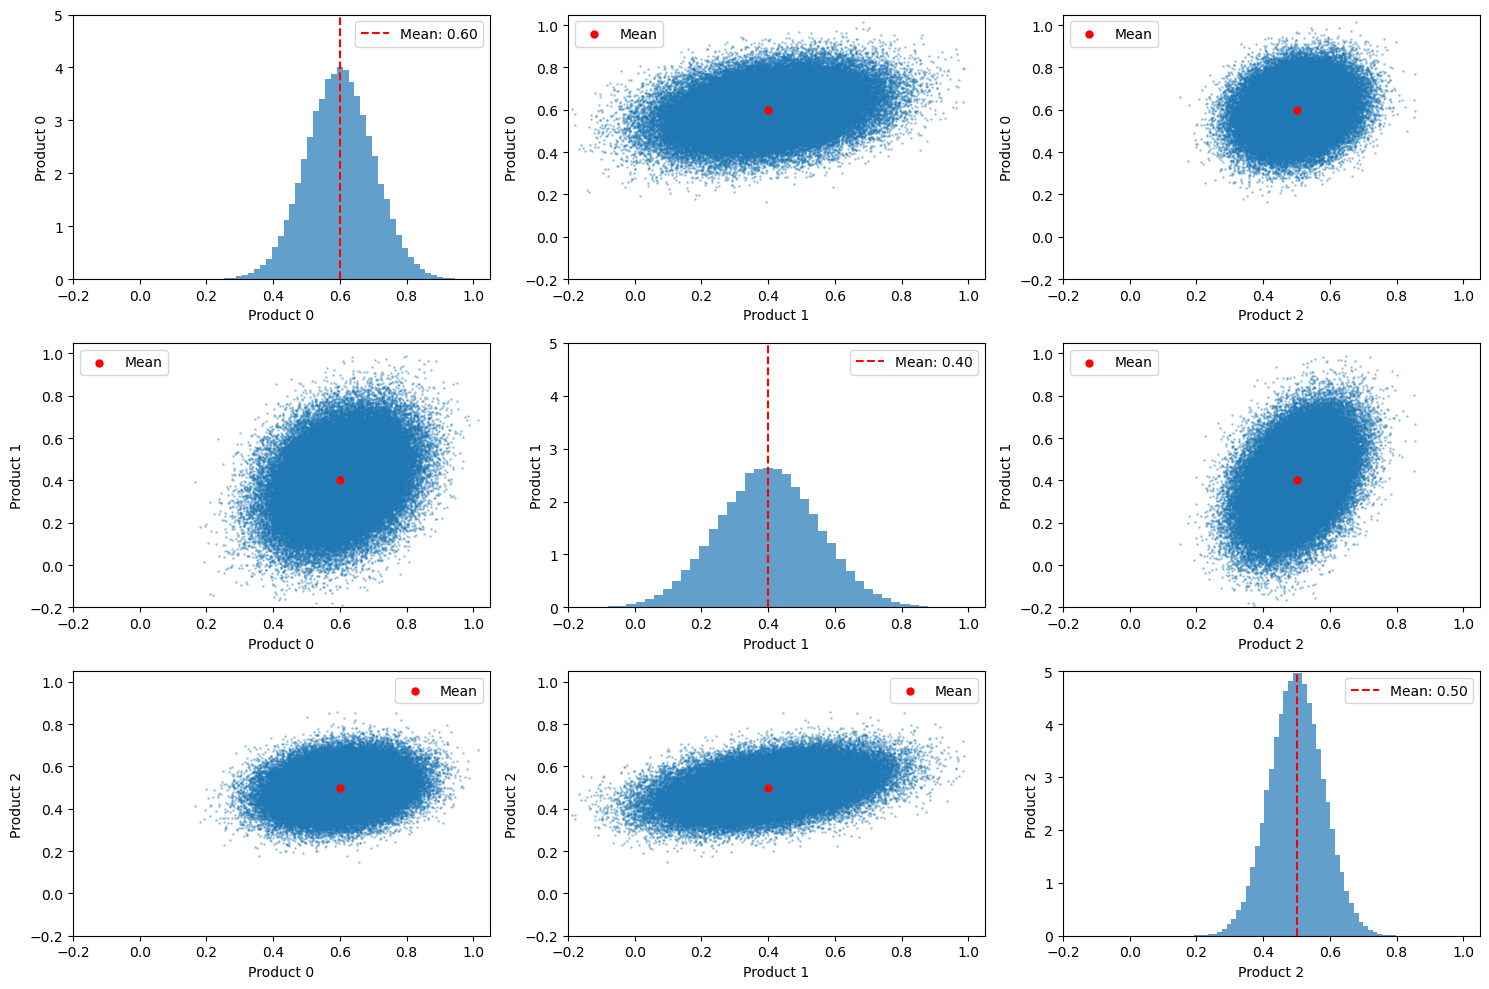


Product valuation distribution:
Means: [0.6, 0.4, 0.5]
Covariances: [[0.01   0.0045 0.0016]
 [0.0045 0.0225 0.0048]
 [0.0016 0.0048 0.0064]]
=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1  0.26 0.42 0.58 0.74 0.9 ]
Initial inventory: [1000, 500, 1500]
Total inventory: 3000

=== Computing Theoretical Optimal ===
Optimal single-product policies:
  Product 0: Price_distribution=[0. , 0. , 0. , 0.5, 0.5, 0. ], Revenue/round=0.198
  Product 1: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.065
  Product 2: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.091

Upper bound total revenue: 3544.58
Upper bound avg revenue/round: 0.354


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


In [8]:
# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products

means = [0.6, 0.4, 0.5]  # Mean valuations for each product
std_devs = [0.1, 0.15, 0.08]  # Standard deviations for each product

D = np.diag(std_devs)

rho12 = 0.3
rho13 = 0.2
rho23 = 0.4
  # aumenta qui (valido finché 0<=rho<=1)
R = np.array([[1,   rho12, rho13],
              [rho12, 1,   rho23],
              [rho13, rho23, 1  ]])
cov = D @ R @ D  # matrice di covarianza PSD

valuation_distributions=stats.multivariate_normal(mean=means, cov=cov)

# Sample points
samples = valuation_distributions.rvs(size=100000)

# Plot pairwise projections
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
labels = ['Product 0', 'Product 1', 'Product 2']

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i == j:
            # Marginal histogram
            ax.hist(samples[:, i], bins=50, density=True, alpha=0.7)
            ax.set_xlim(-0.2, 1.05)
            ax.set_ylim(0, 5)
            
            # Plot the continuous distribution (PDF) for the product
            x_vals = np.linspace(-0.5, 1.5, 100000)
            #pdf_vals = valuation_distributions.pdf(np.column_stack([x_vals, np.zeros_like(x_vals), np.zeros_like(x_vals)]))
            #ax.plot(x_vals, pdf_vals, color='blue', label='PDF', linewidth=2)
            
            # Draw a dashed line for the mean
            ax.axvline(means[i], color='red', linestyle='--', label=f'Mean: {means[i]:.2f}')
            ax.legend()
        else:
            # Scatter for 2D projection
            ax.scatter(samples[:, j], samples[:, i], s=1, alpha=0.3)
            ax.set_xlim(-0.2, 1.05)
            ax.set_ylim(-0.2, 1.05)
            
            # Mark the mean in the scatter plot
            ax.scatter(means[j], means[i], color='red', s=100, marker='.', label='Mean')
            ax.legend()

        ax.set_xlabel(labels[j])
        ax.set_ylabel(labels[i])


plt.tight_layout()
plt.show()


print("\nProduct valuation distribution:")
print(f"Means: {means}")
print(f"Covariances: {cov}")


# Inventory constraints per product
inventory_per_product = [int(T * 0.1), int(T * 0.05), int(T * 0.15)]  # Different inventory levels
inventory=T*inventory_percentage*n_products  # Total inventory across all products

n_prices = 4  # Number of price options per product
# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
#price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
price_options = np.linspace(0.1, 0.9, n_prices+2)  # set of prices

print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")


# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
# optimal_policy = compute_optimal_policy(
#     environment, price_options, inventory_per_product, T
# )

optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='sampling')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


# Agent with 'SAMPLING' selection method


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 6
  Total product-price combinations: 18

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 6000.0
Price options: [0.1  0.26 0.42 0.58 0.74 0.9 ]
Round 1000: Revenue =   0.00, Cumulative =   481.14, Products sold this round = 0, Remaining inventory = 4739
Round 2000: Revenue =   0.00, Cumulative =   865.30, Products sold this round = 0, Remaining inventory = 3867
Round 3000: Revenue =   0.58, Cumulative =  1213.94, Products sold this round = 1, Remaining inventory = 3123
Round 4000: Revenue =   1.16, Cumulative =  1555.86, Products sold this round = 2, Remaining inventory = 2419
Round 5000: Revenue =   0.26, Cumulative =  1873.56, Products sold this round = 1, Remaining inventory = 1786
Round 6000: Revenue =  

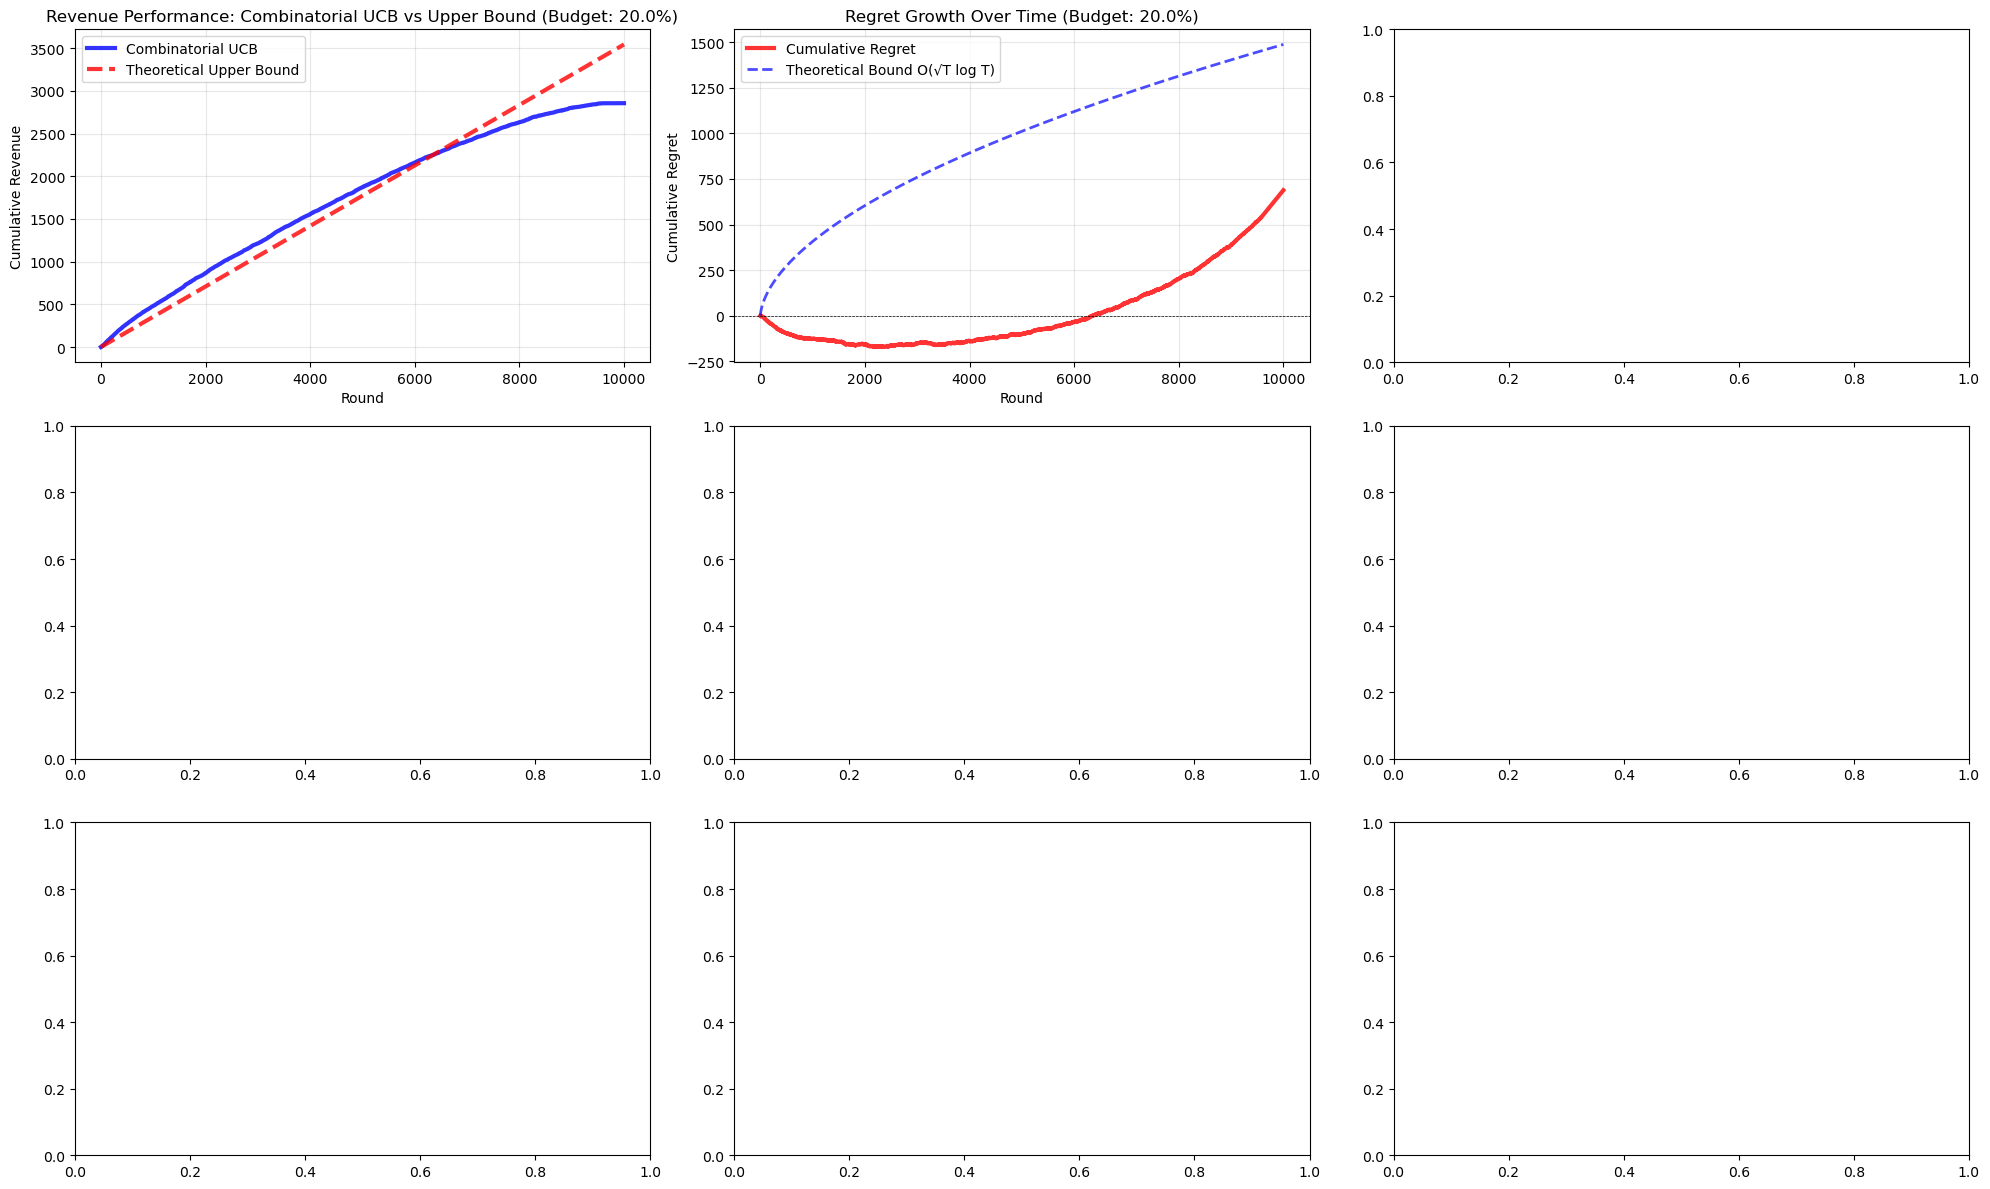


=== Detailed Performance Analysis ===
Total regret: 687.94
Average regret per round: 0.0688
Regret as % of optimal: 19.41%

Exploration statistics:
  Unique actions tried: 189
  Total product-price combinations: 18
  Average actions per round: 0.97

Revenue statistics:
  Mean revenue per round: 0.286
  Std revenue per round: 0.361
  Max revenue in single round: 2.060
  Rounds with zero revenue: 5141 (51.4%)

=== Final Summary ===
Combinatorial UCB achieved 108.9% of theoretical upper bound
Overall inventory utilization: 100.0%


In [9]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

# Calculate inventory based on existing variables
inventory = T * inventory_percentage * n_products


agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='sampling')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Regret Growth"],budget=inventory_percentage)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Agent with 'LINEAR SUM ASSIGNMENT' selection method

In [10]:
optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='lsa')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


Optimal single-product policies:
  Product 0: Price_distribution=[0.  , 0.  , 0.  , 0.49, 0.51, 0.  ], Revenue/round=0.336
  Product 1: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.215
  Product 2: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.353

Upper bound total revenue: 3544.83
Upper bound avg revenue/round: 0.354



=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 6
  Total product-price combinations: 18

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 6000.0
Price options: [0.1  0.26 0.42 0.58 0.74 0.9 ]
Round 1000: Revenue =   0.26, Cumulative =   554.66, Products sold this round = 1, Remaining inventory = 4471
Round 2000: Revenue =   1.26, Cumulative =  1133.72, Products sold this round = 3, Remaining inventory = 2826
Round 3000: Revenue =   1.00, Cumulative =  1509.62, Products sold this round = 2, Remaining inventory = 1811
Round 4000: Revenue =   0.00, Cumulative =  1846.68, Products sold this round = 0, Remaining inventory = 938
Round 5000: Revenue =   0.42, Cumulative =  2169.14, Products sold this round = 1, Remaining inventory = 155
Round 6000: Revenue =   0

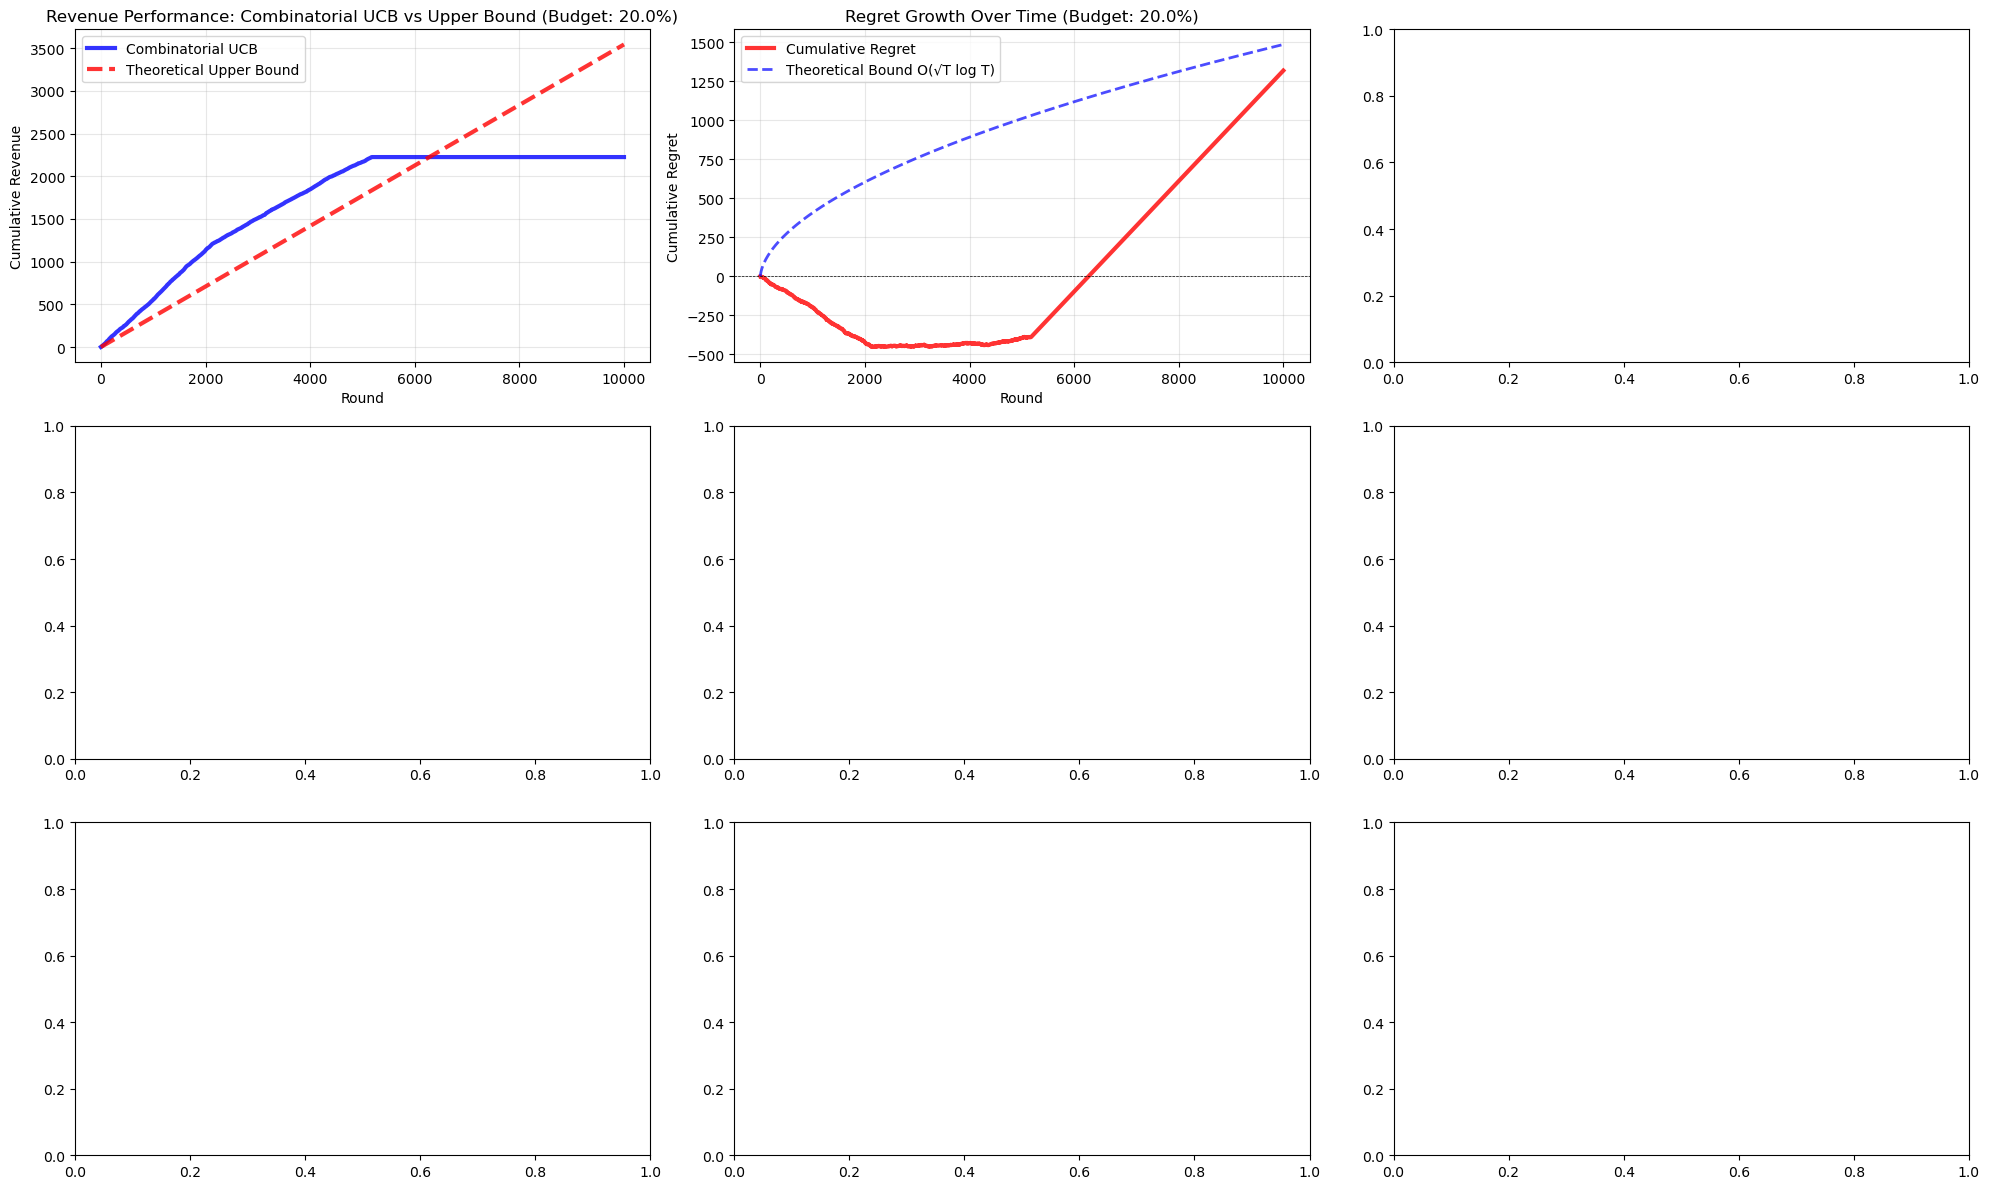


=== Detailed Performance Analysis ===
Total regret: 1319.23
Average regret per round: 0.1319
Regret as % of optimal: 37.22%

Exploration statistics:
  Unique actions tried: 110
  Total product-price combinations: 18
  Average actions per round: 0.52

Revenue statistics:
  Mean revenue per round: 0.223
  Std revenue per round: 0.335
  Max revenue in single round: 1.740
  Rounds with zero revenue: 5975 (59.8%)

=== Final Summary ===
Combinatorial UCB achieved 116.7% of theoretical upper bound
Overall inventory utilization: 100.0%


In [11]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")



agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='lsa')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Regret Growth"],budget=inventory_percentage)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Mid Budget->50%


In [12]:
budget=0.5


In [13]:

# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products


# Inventory constraints per product
inventory_per_product = [int(T * 0.1), int(T * 0.05), int(T * 0.15)]  # Different inventory levels
inventory=T*budget*n_products  # Total inventory across all products


# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")

# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
# optimal_policy = compute_optimal_policy(
#     environment, price_options, inventory_per_product, T
# )

optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='sampling')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Initial inventory: [1000, 500, 1500]
Total inventory: 3000

=== Computing Theoretical Optimal ===
Optimal single-product policies:
  Product 0: Price_distribution=[0.  , 0.  , 0.  , 0.27, 0.73, 0.  , 0.  ], Revenue/round=0.327
  Product 1: Price_distribution=[0., 0., 0., 1., 0., 0., 0.], Revenue/round=0.143
  Product 2: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.,  0.], Revenue/round=0.291

Upper bound total revenue: 7613.92
Upper bound avg revenue/round: 0.761


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


# Agent with 'SAMPLING' selection method


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 15000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.58, Cumulative =   706.47, Products sold this round = 2, Remaining inventory = 12946
Round 2000: Revenue =   1.31, Cumulative =  1461.36, Products sold this round = 3, Remaining inventory = 10971
Round 3000: Revenue =   0.96, Cumulative =  2167.65, Products sold this round = 2, Remaining inventory = 9235
Round 4000: Revenue =   0.48, Cumulative =  2856.32, Products sold this round = 1, Remaining inventory = 7611
Round 5000: Revenue =   0.96, Cumulative =  3530.70, Products sold this round = 2,

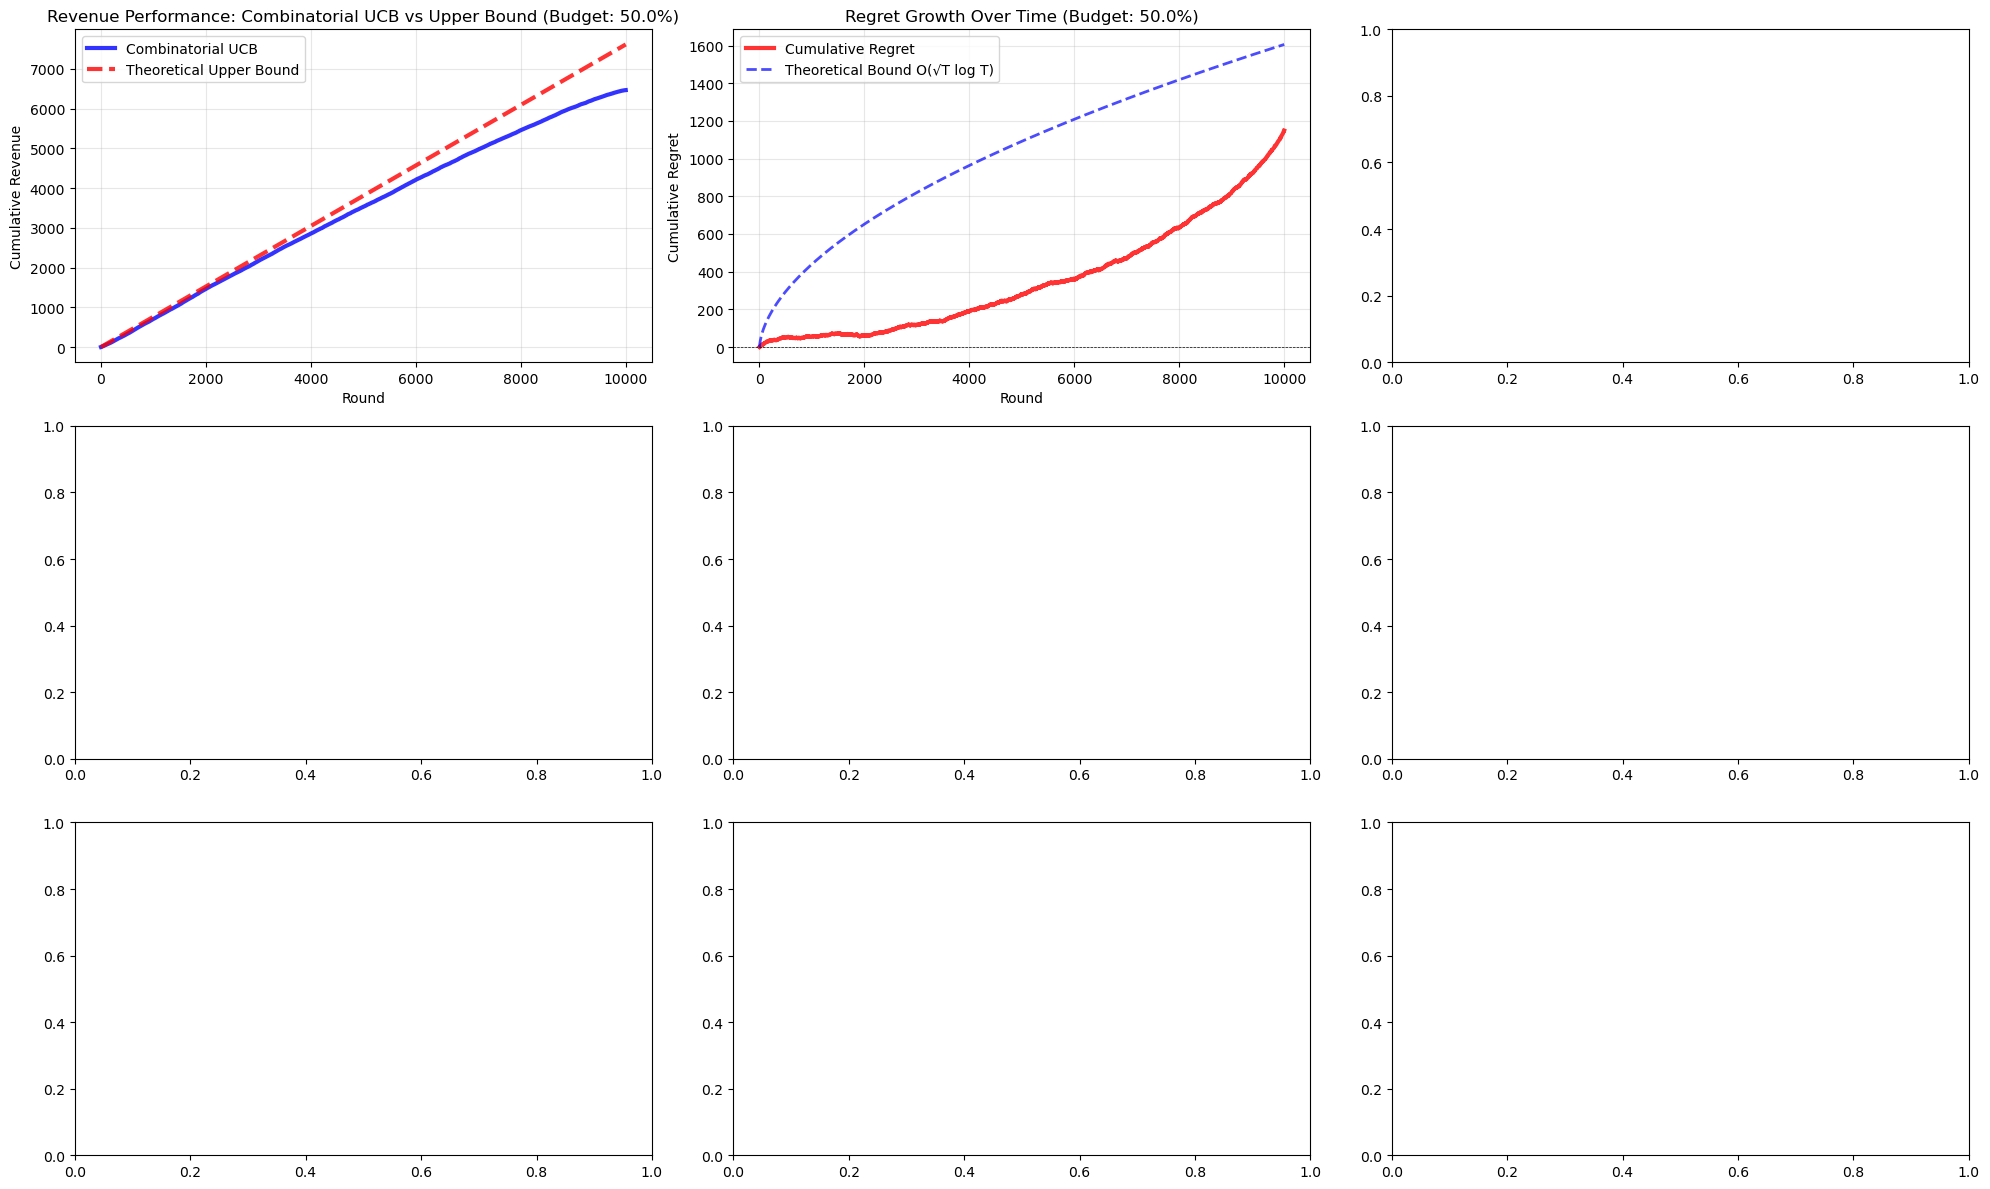


=== Detailed Performance Analysis ===
Total regret: 1148.82
Average regret per round: 0.1149
Regret as % of optimal: 15.09%

Exploration statistics:
  Unique actions tried: 311
  Total product-price combinations: 21
  Average actions per round: 1.00

Revenue statistics:
  Mean revenue per round: 0.647
  Std revenue per round: 0.393
  Max revenue in single round: 1.938
  Rounds with zero revenue: 1217 (12.2%)

=== Final Summary ===
Combinatorial UCB achieved 91.2% of theoretical upper bound
Overall inventory utilization: 100.0%


In [14]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")



agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='sampling')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Regret Growth"],budget=budget)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Agent with 'LINEAR SUM ASSIGNMENT' selection method

In [15]:
optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='lsa')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


Optimal single-product policies:
  Product 0: Price_distribution=[0.  , 0.  , 0.  , 0.27, 0.73, 0.  , 0.  ], Revenue/round=0.293
  Product 1: Price_distribution=[0., 0., 0., 1., 0., 0., 0.], Revenue/round=0.198
  Product 2: Price_distribution=[ 0.,  0.,  0.,  1., -0.,  0.,  0.], Revenue/round=0.291

Upper bound total revenue: 7617.60
Upper bound avg revenue/round: 0.762



=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 15000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   1.06, Cumulative =   719.15, Products sold this round = 3, Remaining inventory = 12857
Round 2000: Revenue =   1.06, Cumulative =  1502.64, Products sold this round = 3, Remaining inventory = 10630
Round 3000: Revenue =   1.06, Cumulative =  2308.03, Products sold this round = 3, Remaining inventory = 8373
Round 4000: Revenue =   0.70, Cumulative =  3017.20, Products sold this round = 2, Remaining inventory = 6447
Round 5000: Revenue =   0.35, Cumulative =  3705.51, Products sold this round = 1,

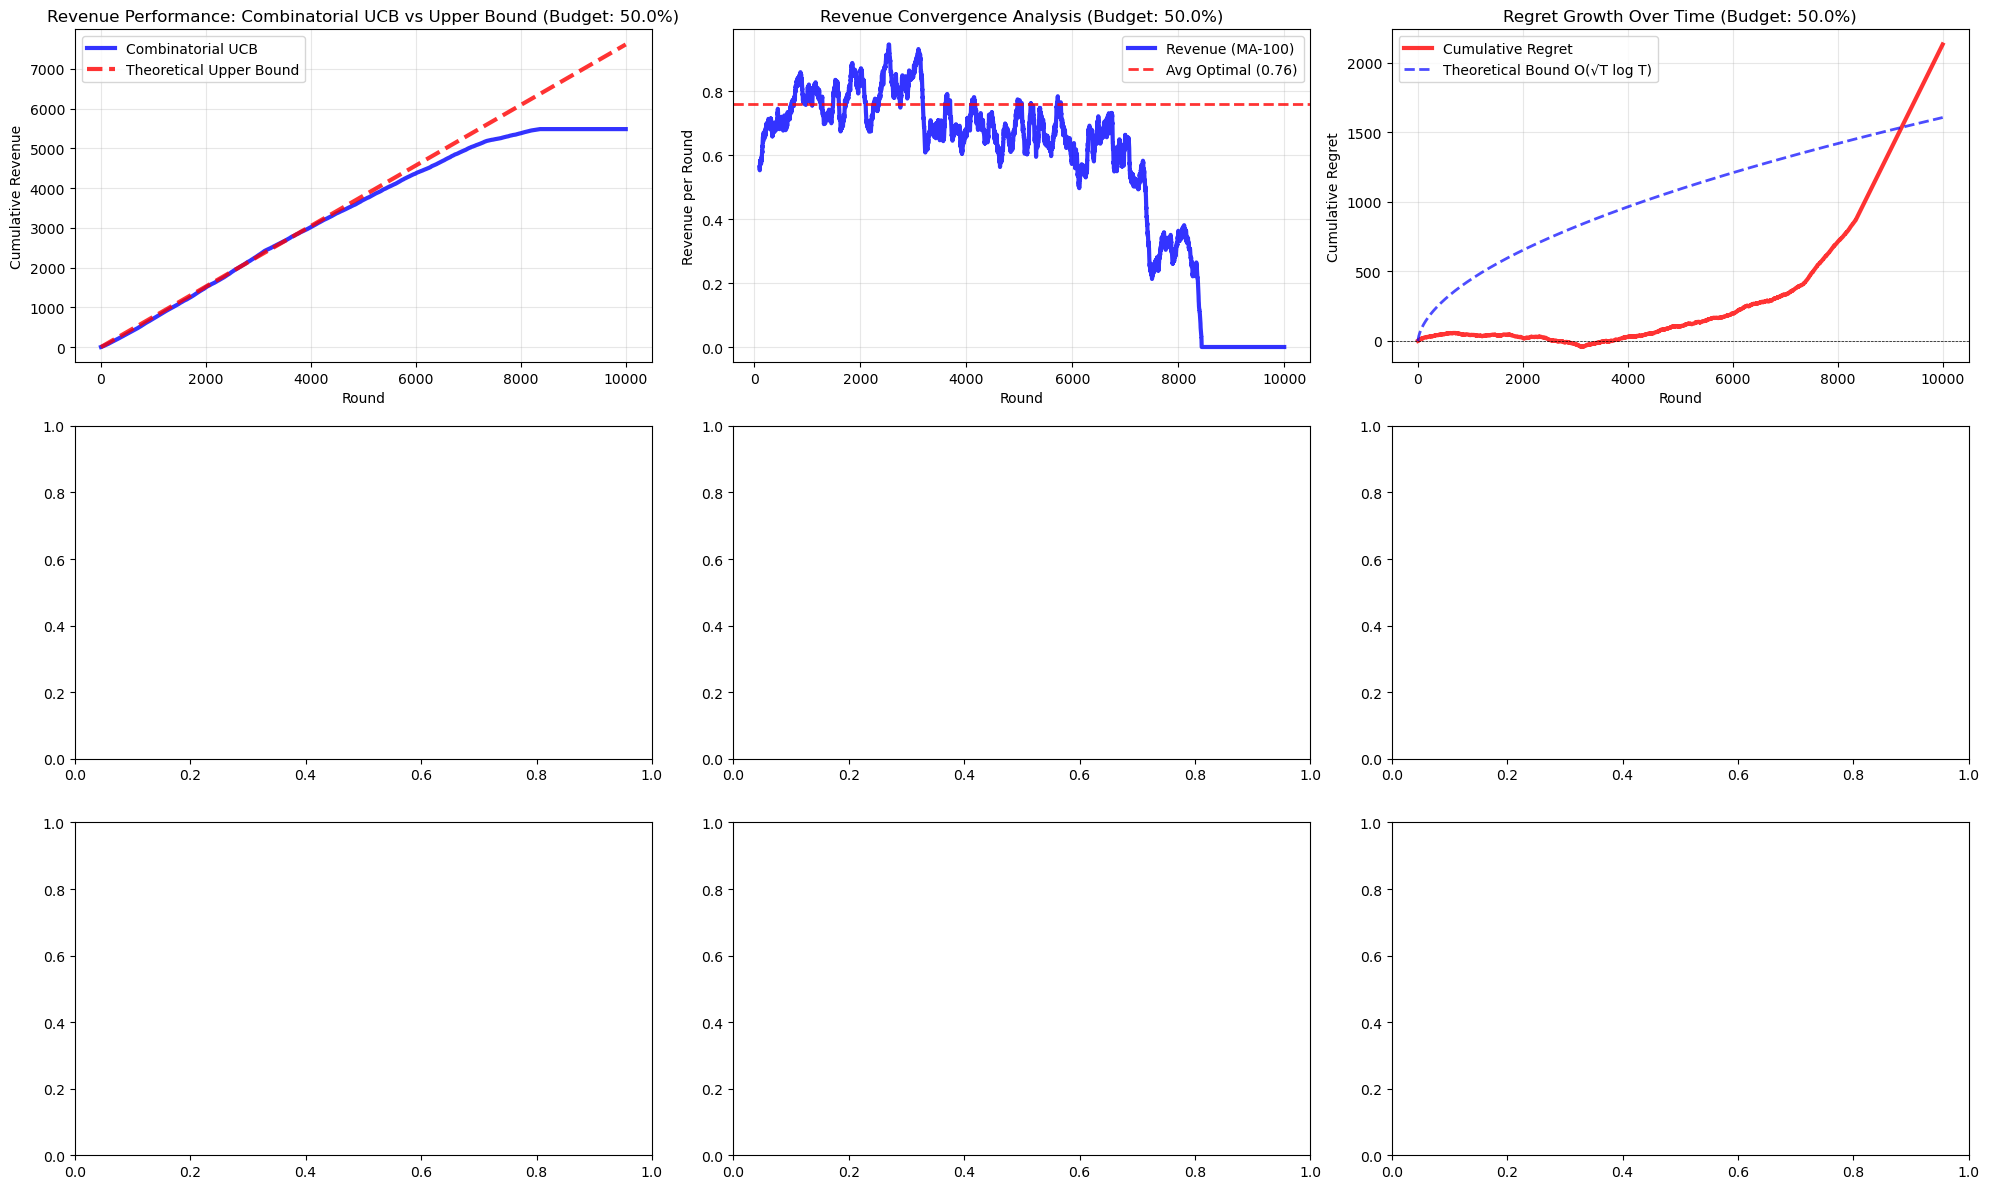


=== Detailed Performance Analysis ===
Total regret: 2130.98
Average regret per round: 0.2131
Regret as % of optimal: 27.97%

Exploration statistics:
  Unique actions tried: 184
  Total product-price combinations: 21
  Average actions per round: 0.83

Revenue statistics:
  Mean revenue per round: 0.549
  Std revenue per round: 0.420
  Max revenue in single round: 1.812
  Rounds with zero revenue: 2323 (23.2%)

=== Final Summary ===
Combinatorial UCB achieved 92.3% of theoretical upper bound
Overall inventory utilization: 100.0%


In [16]:


# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")


agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='lsa')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Revenue Convergence", "Regret Growth"],budget=budget)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# High Budget -> 80% of the total T

In [17]:
budget=0.8

In [18]:
# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products


# Inventory constraints per product
inventory_per_product = [int(T * 0.1), int(T * 0.05), int(T * 0.15)]  # Different inventory levels
inventory=T*budget*n_products  # Total inventory across all products


# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")

# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
# optimal_policy = compute_optimal_policy(
#     environment, price_options, inventory_per_product, T
# )

optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='sampling')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Initial inventory: [1000, 500, 1500]
Total inventory: 3000

=== Computing Theoretical Optimal ===


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


Optimal single-product policies:
  Product 0: Price_distribution=[0., 0., 0., 1., 0., 0., 0.], Revenue/round=0.424
  Product 1: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.220
  Product 2: Price_distribution=[0.  , 0.  , 0.77, 0.23, 0.  , 0.  , 0.  ], Revenue/round=0.329

Upper bound total revenue: 9740.62
Upper bound avg revenue/round: 0.974


# Agent with 'SAMPLING' selection method


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 24000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.93, Cumulative =   700.77, Products sold this round = 3, Remaining inventory = 21935
Round 2000: Revenue =   0.93, Cumulative =  1525.40, Products sold this round = 3, Remaining inventory = 19662
Round 3000: Revenue =   0.83, Cumulative =  2380.89, Products sold this round = 2, Remaining inventory = 17326
Round 4000: Revenue =   1.06, Cumulative =  3254.75, Products sold this round = 3, Remaining inventory = 14979
Round 5000: Revenue =   0.83, Cumulative =  4161.88, Products sold this round = 

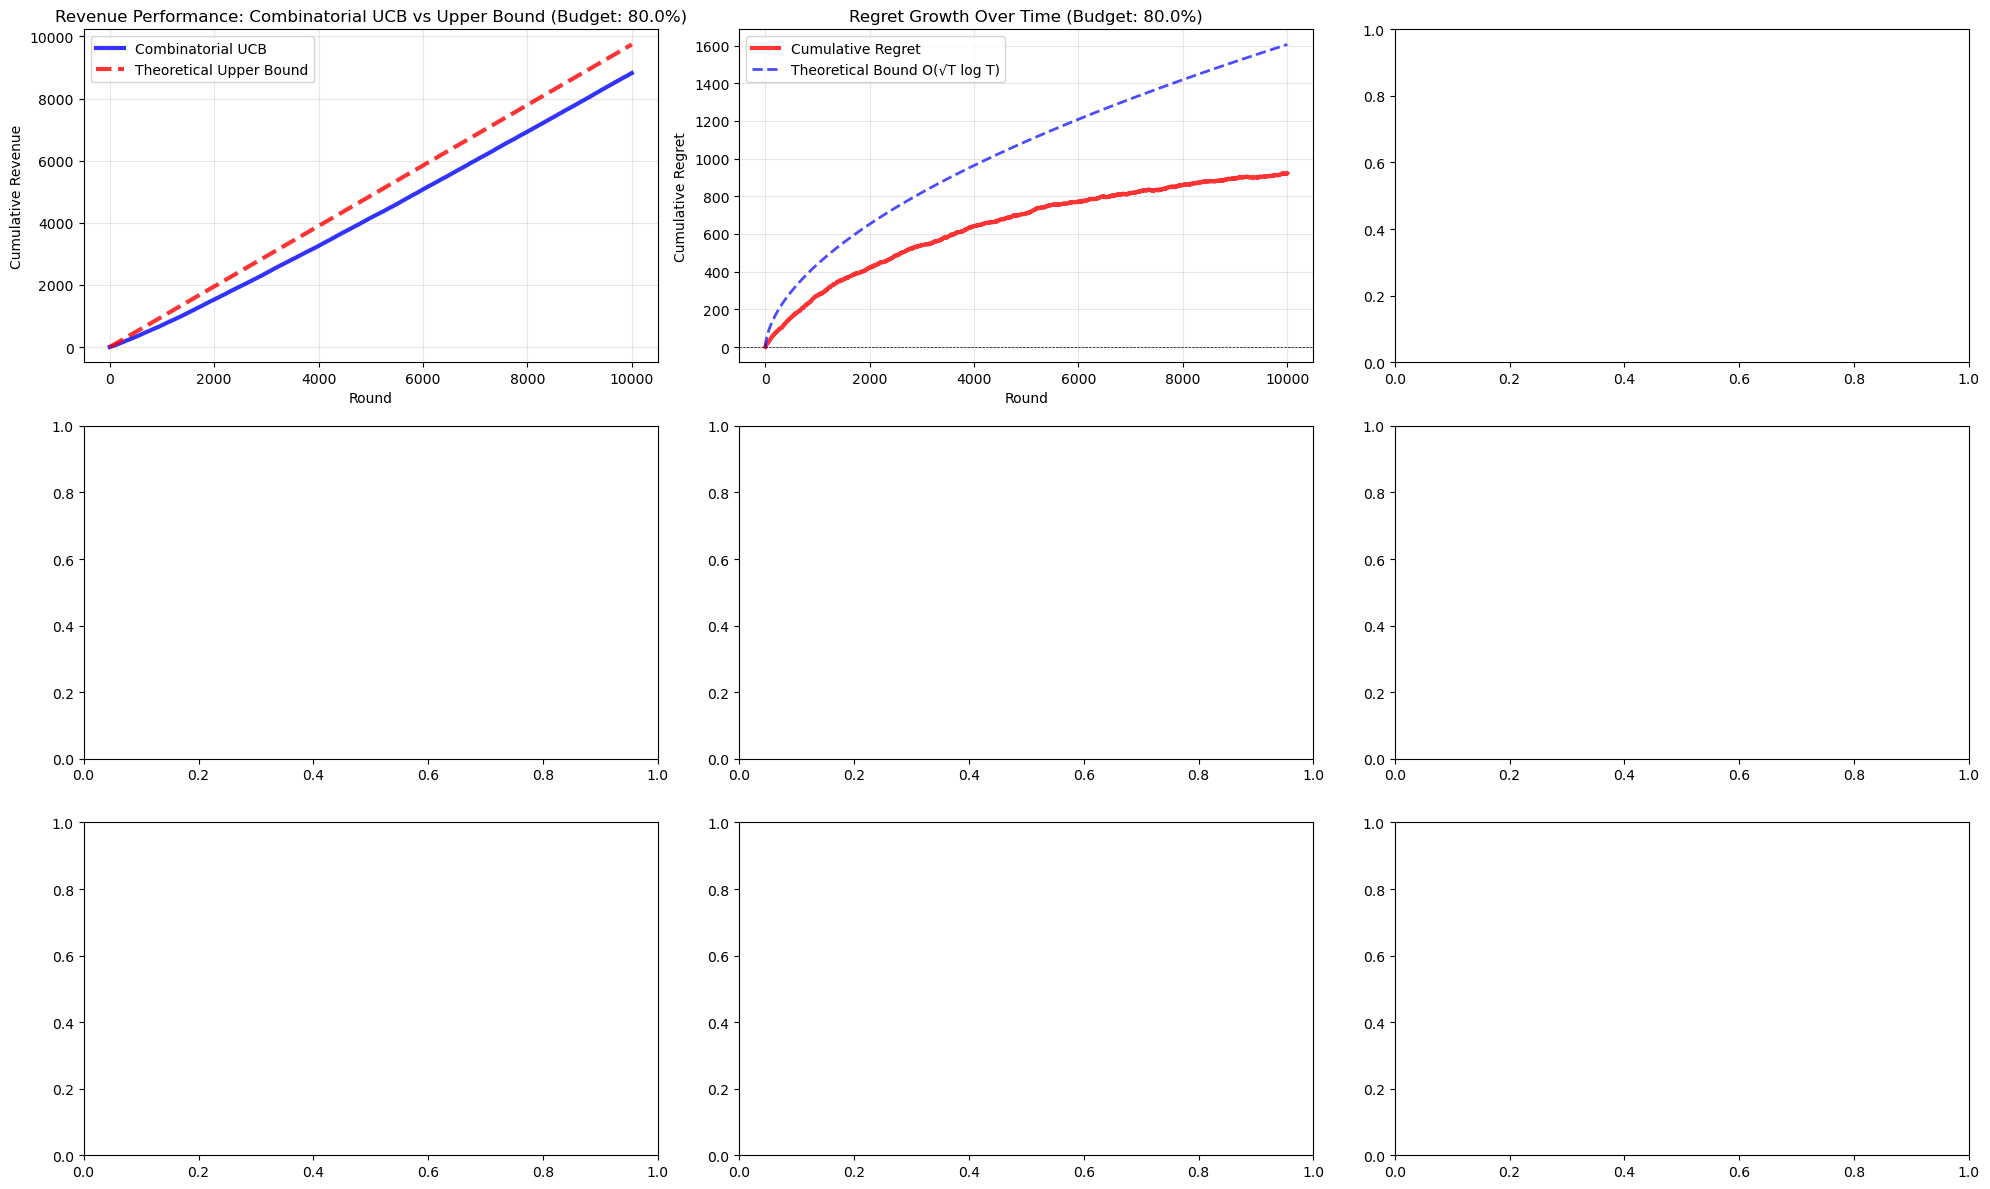


=== Detailed Performance Analysis ===
Total regret: 921.36
Average regret per round: 0.0921
Regret as % of optimal: 9.46%

Exploration statistics:
  Unique actions tried: 259
  Total product-price combinations: 21
  Average actions per round: 1.00

Revenue statistics:
  Mean revenue per round: 0.882
  Std revenue per round: 0.292
  Max revenue in single round: 1.560
  Rounds with zero revenue: 127 (1.3%)

=== Final Summary ===
Combinatorial UCB achieved 83.0% of theoretical upper bound
Overall inventory utilization: 98.9%


In [19]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")



agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='sampling')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Regret Growth"],budget=budget)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Agent with 'LINEAR SUM ASSIGNMENT' selection method

In [20]:
optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='lsa')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


C:\Users\marce\AppData\Local\Temp\ipykernel_3300\351468228.py:286: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand_probabilities[product_idx, price_idx] = environment.demand_probability([price]*environment.n_products, [product_idx])


Optimal single-product policies:
  Product 0: Price_distribution=[0., 0., 0., 1., 0., 0., 0.], Revenue/round=0.425
  Product 1: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.098
  Product 2: Price_distribution=[0.  , 0.  , 0.76, 0.24, 0.  , 0.  , 0.  ], Revenue/round=0.341

Upper bound total revenue: 9751.81
Upper bound avg revenue/round: 0.975



=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 24000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.48, Cumulative =   739.17, Products sold this round = 1, Remaining inventory = 21779
Round 2000: Revenue =   1.06, Cumulative =  1567.86, Products sold this round = 3, Remaining inventory = 19352
Round 3000: Revenue =   0.58, Cumulative =  2451.50, Products sold this round = 2, Remaining inventory = 16814
Round 4000: Revenue =   1.06, Cumulative =  3344.28, Products sold this round = 3, Remaining inventory = 14250
Round 5000: Revenue =   0.00, Cumulative =  4262.56, Products sold this round = 

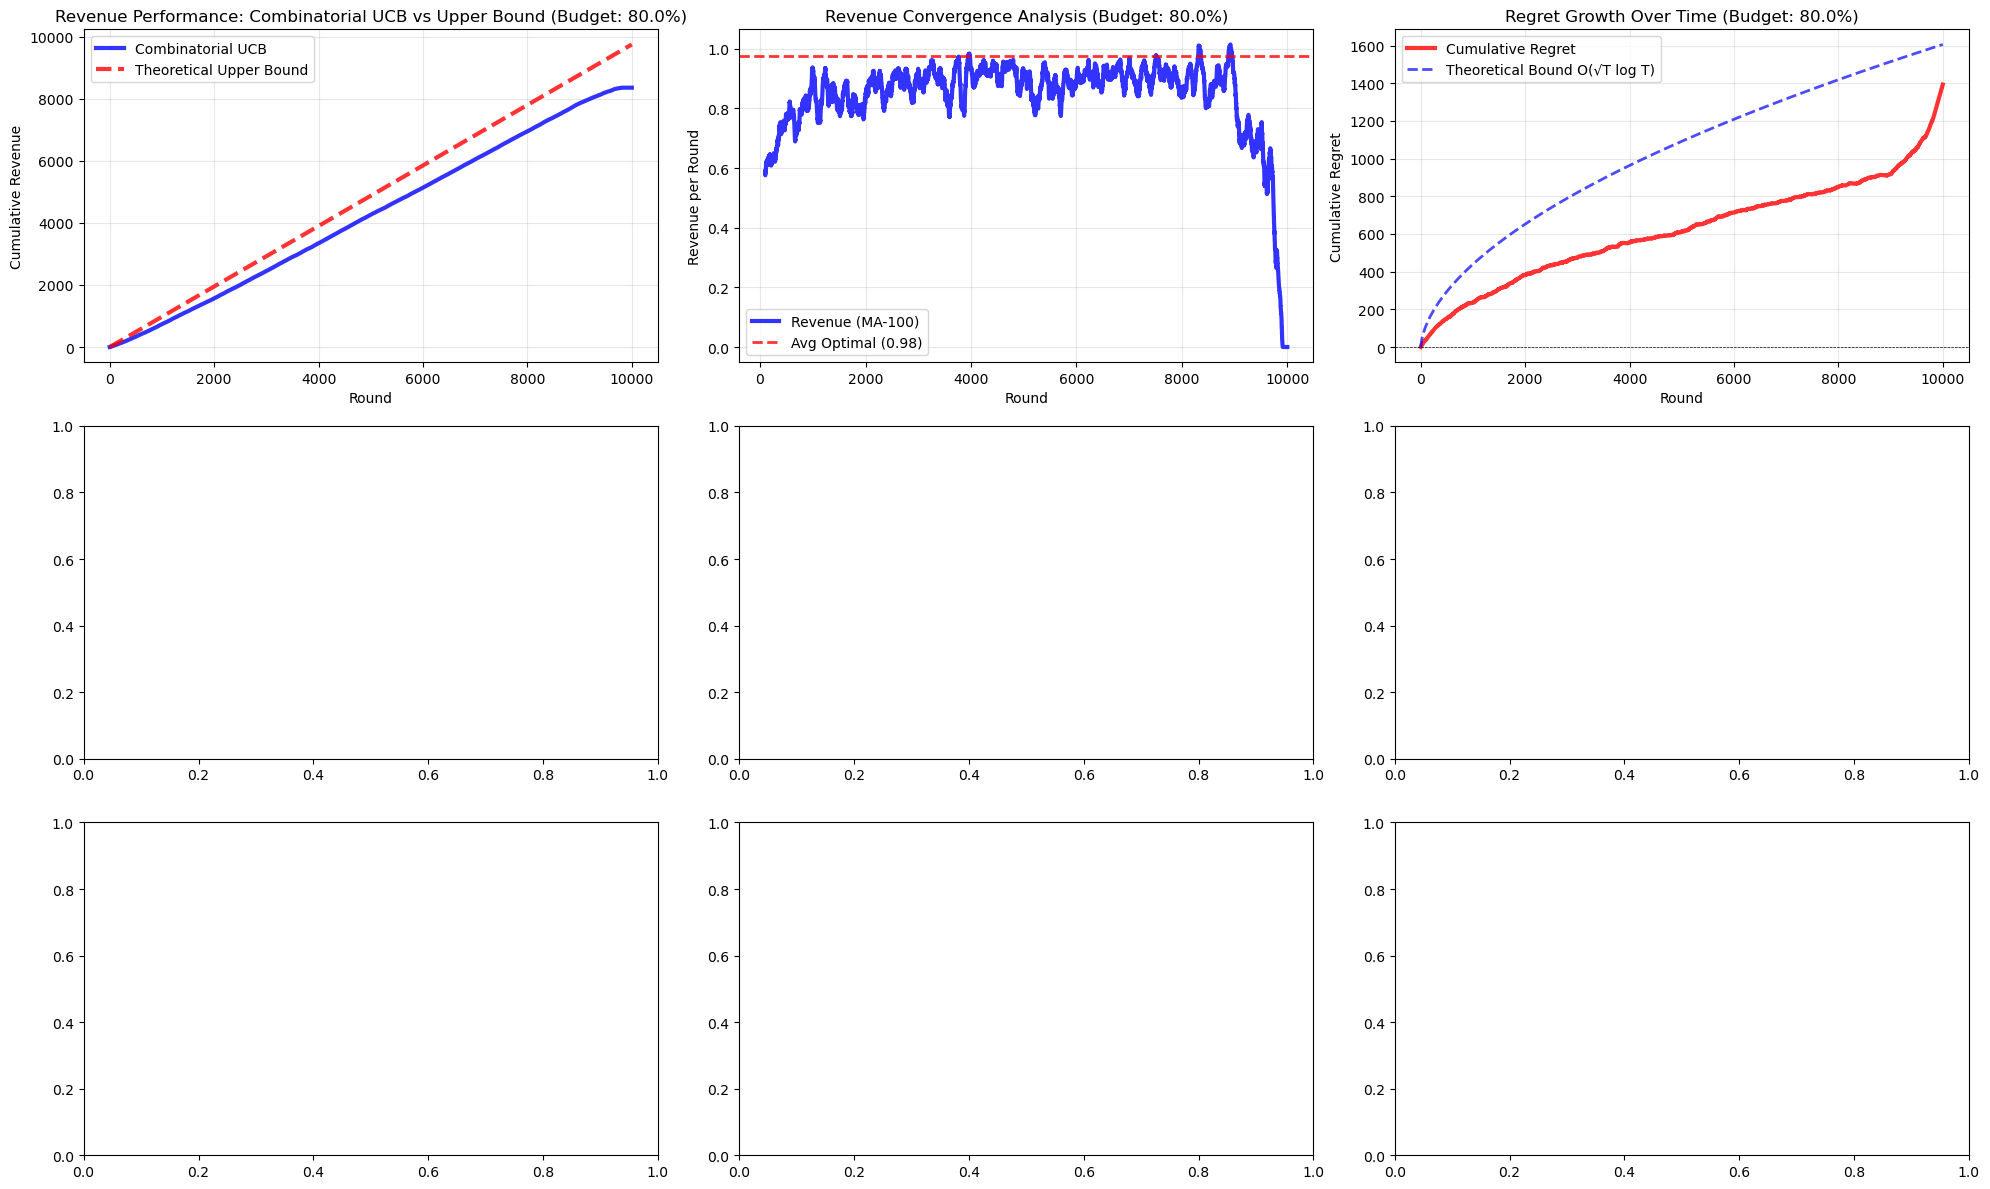


=== Detailed Performance Analysis ===
Total regret: 1393.01
Average regret per round: 0.1393
Regret as % of optimal: 14.28%

Exploration statistics:
  Unique actions tried: 169
  Total product-price combinations: 21
  Average actions per round: 0.98

Revenue statistics:
  Mean revenue per round: 0.836
  Std revenue per round: 0.311
  Max revenue in single round: 1.560
  Rounds with zero revenue: 379 (3.8%)

=== Final Summary ===
Combinatorial UCB achieved 84.2% of theoretical upper bound
Overall inventory utilization: 100.0%


In [21]:


# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")


agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='lsa')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment,plot_titles=["Revenue Performance", "Revenue Convergence", "Regret Growth"],budget=budget)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")